# DESAFIO 2 - Parte Individual - MARCELO COLONNO

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import random

import warnings
warnings.filterwarnings("ignore")

# Pense na hipótese de duas universidades A e B onde X é a média de notas delas e elas tem exatamente os mesmos cursos
# É possível que A_X > B_X e TODOS os cursos de B sejam melhores (notas maiores) que os de A? Explique

<font color='blue' size=4>
O PARADOXO DE SIMPSON ou efeito Yule-Simpson é um fenômeno estatístico que contraria a tendência de um evento quando suas parciais adquirem configuração específicas, que permitem a mudança na interpretação de dados conforme os resultados probabilísticos assimétricos em comparação com o total de uma amostra. Isto signigica que se uma probabilidade de ocorrência para uma amostra revela uma tendência, esta pode não se confirmar quando se faz a análise em grupos parciais que constituem a amostra total.
    
Podemos pensar que em um gráfico de distribução onde, se traçarmos uma regressão linear com a população total, esta terá uma inclinação com a correlação entre as variáveis, porém se dividirmos esta população em clusters, todas as regressões lineares parcias terão inclinação oposta à obtida para a amostra total, demonstrando que o cálculo estatístico pode apresentar resultado enganoso, dependendo da divisão adtada para a amostra.abaixo).

Existem exemplos clássicos para comprovar que o evento total pode ter efeito positivo, mas parcialmente se obtém efeitos negativos. Um deles é o do médico que apurou resultados para dois tratamentos distintos de cálculo renal, sendo o primeiro com 273/350 (78%) de sucesso contra o segundo com 289/350 (83%) de sucesso, o que nos permite afirmar que o segundo é o melhor tratamento, mas o médico acabou por dividir os tratamentos em dois grupos, sendo o primeiro com sucesso de 192/263 (73%) para pedras grandes e 81/87 (93%) de sucesso para pedras pequenas, contra a divisão do segundo grupo apresentando sucesso de 55/80 (69%) para pedras grandes e 234/270 (87%) de sucesso para pedras pequenas, o que comprova que o primeiro tratamento é mais eficaz, contrariando a afirmação anterior. Em ambos os casos, o total de pacientes é 350 (código abaixo).

O mais importante é entender que a definição de clusters para a amostra pode alterar o resultado do grupo e modificar a análise da correlação entre variáveis, quando analisadas de forma linear, mas trata-se de um evento raro, que pode ocorrer mesmo sem ser percebido, e posteriormente causar enganos e até constragimentos, induzindo o cientista de dados ao erro. Ainda, o paradoxo de Simpson tem ocorrência com probabilidade que, apesar de muito baixa, pode aumentar com o aumento da dispersão dos dados de cada cluster ou grupo de dados perencentes à amostra total original, demosntrado abaixo pela simulação de MonteCarlo, cujo aumento no tamanho dos dados parciais (aleatório), acarreta em um aumento da probabilidade de incidência do paradoxo de Simpson.

# Código para demonstração do paradoxo de Simpson segundo o exemplo do médico que utilizou dois tratamentos para cálculo renal

In [8]:
# detect simpson's paradox
import numpy as np
import pandas as pd


def aggregate_data(df, conversion_col, treatment_col, segment_col):
    """
    takes table of individual level data and aggregates it for simpsons paradox detection.
    conversion_col is 1 if success, 0 else. 
    ex:
    pd.DataFrame([
        ['small', 'A', 1],
        ['small', 'B', 0],
        ['large', 'A', 1],
        ['small', 'A', 1],
        ['large', 'B', 0],
        ['large', 'B', 0],
    ], columns=['kidney_stone_size', 'treatment', 'recovery'])   
    """
    df_ = df[[conversion_col, treatment_col, segment_col]]
    gb = df_.groupby([segment_col, treatment_col]).agg(
        [np.sum, lambda x: len(x)])
    gb.columns = [conversion_col, "total"]

    return gb.reset_index()


def simpsons_paradox(df, conversion_col, total_col, treatment_col, segment_col):
    """
    given a dataframe like:
        pd.DataFrame([
            ['small', 'A', 81, 87],
            ['small', 'B', 234, 270],
            ['large', 'A', 192, 263],
            ['large', 'B', 55, 80],
        ], columns=['kidney_stone_size', 'treatment', 'recovery', 'total'])   
    will determine if simpsons paradox exists. Non Bayesian!
    > simpsons_paradox( df, 'recovery', 'total', 'treatment', 'kidney_stone_size' )    
    """

    # find global optimal:
    gbs = df.groupby(treatment_col).sum()
    print ("## Global rates: ")
    print (gbs[conversion_col] / gbs[total_col])
    print
    global_optimal = (gbs[conversion_col] / gbs[total_col]).argmax()

    # check optimal via segments
    df_ = df.set_index([segment_col, treatment_col])
    rates = (df_[conversion_col] / df_[total_col]).unstack(-1)
    print ("## Local rates:")
    print (rates)
    print
    # find the local optimals
    local_optimals = rates.apply(lambda x: x.argmax(), 1)

    if local_optimals.unique().shape[0] > 1:
        print ("## Simpsons paradox not detected.")
        print ("## Segmented rates do not have a consistent optimal choice")
        print ("## Local optimals:")
        print (local_optimals)
        print ("## Global optimal: ", global_optimal)
        return False

    local_optimal = local_optimals.unique()[0]

    print ("## Global optimal: ", global_optimal)
    print ("## Local optimal: ", local_optimal)
    if local_optimal != global_optimal:
        print ("## Simpsons Paradox detected.")
        return True

    else:
        print ("## Simpsons paradox not detected.")
        return False


if __name__ == "__main__":
    # create some data, indentical to the data at
    # http://en.wikipedia.org/wiki/Simpsons_paradox
    d = []
    d += ([('A', 'small', 1)] * 81)
    d += ([('A', 'small', 0)] * (87 - 81))
    d += ([('B', 'small', 0)] * (270 - 234))
    d += ([('B', 'small', 1)] * (234))
    d += ([('B', 'large', 1)] * (55))
    d += ([('B', 'large', 0)] * (80 - 55))
    d += ([('A', 'large', 0)] * (263 - 192))
    d += ([('A', 'large', 1)] * (192))

    df = pd.DataFrame(
        d, columns=['treatment', 'kidney_stone_size', 'recovery'])
    gb = aggregate_data(df, 'recovery', 'treatment', 'kidney_stone_size')
simpsons_paradox(gb, 'recovery', 'total', 'treatment', 'kidney_stone_size')

## Global rates: 
treatment
A    0.780000
B    0.825714
dtype: float64
## Local rates:
treatment                 A         B
kidney_stone_size                    
large              0.730038  0.687500
small              0.931034  0.866667
## Global optimal:  B
## Local optimal:  A
## Simpsons Paradox detected.


True

# Código de probabilidade de incidência do paradoxo de Simpson de acordo com a dispersão dos dados parciais dos grupos (clusters)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

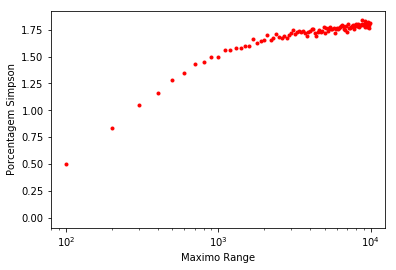

In [9]:
def checkSimpson(nAD,nAE,nARD,nARE,nBD,nBE,nBRD,nBRE):
    nA=nAD+nAE    
    pRAD=nARD/nAD
    pRAE=nARE/nAE
    pDA=nAD/nA
    pEA=nAE/nA
    pRA=pRAD*pDA+pRAE*pEA


    nB=nBD+nBE    
    pRBD=nBRD/nBD
    pRBE=nBRE/nBE
    pDB=nBD/nB
    pEB=nBE/nB
    pRB=pRBD*pDB+pRBE*pEB      

    if(((pRAD>pRBD) and (pRAE>pRBE) and (pRA<pRB)) or ((pRAD<pRBD) and (pRAE<pRBE) and (pRA>pRB))):
        return True
    else:
        return False

if __name__ == '__main__':


    minimalSize=50
    step=100
    numberRepetitions=500000
    sizeExperiment=100

    porcentPositive=np.zeros([sizeExperiment])
    maxRange=np.empty([sizeExperiment])

    for i in range(sizeExperiment):
        #print (i)
        maximalSize=minimalSize+i*step
        for j in range(numberRepetitions):

            nAD=1.0*random.randint(minimalSize,maximalSize)
            nAE=1.0*random.randint(minimalSize,maximalSize)
            nARD=1.0*random.randint(0,nAD)
            nARE=1.0*random.randint(0,nAE)

            nBD=1.0*random.randint(minimalSize,maximalSize)
            nBE=1.0*random.randint(minimalSize,maximalSize)
            nBRD=1.0*random.randint(0,nBD)
            nBRE=1.0*random.randint(0,nBE)
            if(checkSimpson(nAD,nAE,nARD,nARE,nBD,nBE,nBRD,nBRE)):
                porcentPositive[i]=porcentPositive[i]+1.0    
        porcentPositive[i]=(porcentPositive[i]/numberRepetitions)*100
        maxRange[i]=maximalSize-minimalSize

    fig = plt.figure()
    ax = fig.add_subplot(111)  
    fig.hold()    
    ax.plot(maxRange,porcentPositive,'r.')
    ax.set_xscale('log')
    ax.set_ylabel('Porcentagem Simpson')
    ax.set_xlabel('Maximo Range')  

<font color='blue' size=4>
O range da diferença de tamanho das amostras faz com que a chance de incidência do paradoxo da Simpson aumente, gerando uma interpretação enganosa para as porcentagens de eventos parciais em relação às porcentagens totais. Isto se deve ao fato das dispersões dos tamanhos das categorias terem significativo aumento, como consequência da diferente forma de ponderação dos cálculos,

# 2. Rode uma regressão múltipla que use, entre outras, a carga horária de um curso como variável independente para explicar a idade dos alunos formados

In [13]:
import pandas as pd
import numpy as np
import random

n = 11449222 #number of rows
s = 10000 #desired sample size
df_alunos = pd.read_csv('DM_ALUNO.CSV', skiprows=sorted(random.sample(range(1,n),n-s)),delimiter='|',encoding='latin1', engine='c',low_memory=True)

In [14]:
df_alunos

,CO_IES,NO_IES,CO_CATEGORIA_ADMINISTRATIVA,DS_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,DS_ORGANIZACAO_ACADEMICA,CO_CURSO,NO_CURSO,CO_CURSO_POLO,CO_TURNO_ALUNO,...,IN_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA_INTERN,CO_IES_DESTINO,CO_PAIS_DESTINO,IN_MATRICULA,IN_CONCLUINTE,IN_INGRESSO_TOTAL,IN_INGRESSO_VAGA_NOVA,ANO_INGRESSO
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,DIREITO,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,1,0,0,0,2013
1,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,2,CIÊNCIAS ECONÔMICAS,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,2012
2,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,3,ENGENHARIA CIVIL,NaN,4.0,...,0.0,NaN,NaN,NaN,NaN,1,0,0,0,2015
3,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,3,ENGENHARIA CIVIL,NaN,4.0,...,0.0,NaN,NaN,NaN,NaN,1,0,1,1,2016
4,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,3,ENGENHARIA CIVIL,NaN,4.0,...,0.0,NaN,NaN,NaN,NaN,1,0,1,1,2016
5,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,12,MEDICINA,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2010
6,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,12,MEDICINA,NaN,4.0,...,0.0,NaN,NaN,NaN,NaN,1,0,0,0,2012
7,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,13,ADMINISTRAÇÃO,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,2011
8,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,13,ADMINISTRAÇÃO,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,2012
9,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,15,GEOLOGIA,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2010


In [15]:
df_carga = df_alunos[df_alunos['CO_ALUNO_SITUACAO'] == 6]
df_carga

,CO_IES,NO_IES,CO_CATEGORIA_ADMINISTRATIVA,DS_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,DS_ORGANIZACAO_ACADEMICA,CO_CURSO,NO_CURSO,CO_CURSO_POLO,CO_TURNO_ALUNO,...,IN_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA_INTERN,CO_IES_DESTINO,CO_PAIS_DESTINO,IN_MATRICULA,IN_CONCLUINTE,IN_INGRESSO_TOTAL,IN_INGRESSO_VAGA_NOVA,ANO_INGRESSO
5,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,12,MEDICINA,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2010
9,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,15,GEOLOGIA,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2010
20,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,100802,ENGENHARIA MECÂNICA,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2010
43,2,UNIVERSIDADE DE BRASÍLIA,1,Pública Federal,1,Universidade,167,CIÊNCIAS CONTÁBEIS,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2012
54,2,UNIVERSIDADE DE BRASÍLIA,1,Pública Federal,1,Universidade,112816,TERAPIA OCUPACIONAL,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2011
80,3,UNIVERSIDADE FEDERAL DE SERGIPE,1,Pública Federal,1,Universidade,319,ENGENHARIA AGRONÔMICA,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2012
114,4,UNIVERSIDADE FEDERAL DO AMAZONAS,1,Pública Federal,1,Universidade,381,PEDAGOGIA,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2010
127,4,UNIVERSIDADE FEDERAL DO AMAZONAS,1,Pública Federal,1,Universidade,402,HISTÓRIA,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2011
131,4,UNIVERSIDADE FEDERAL DO AMAZONAS,1,Pública Federal,1,Universidade,62486,MÚSICA,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2012
146,5,UNIVERSIDADE FEDERAL DO PIAUÍ,1,Pública Federal,1,Universidade,495,GEOGRAFIA,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2011


In [16]:
list(df_carga)

['CO_IES',
 'NO_IES',
 'CO_CATEGORIA_ADMINISTRATIVA',
 'DS_CATEGORIA_ADMINISTRATIVA',
 'CO_ORGANIZACAO_ACADEMICA',
 'DS_ORGANIZACAO_ACADEMICA',
 'CO_CURSO',
 'NO_CURSO',
 'CO_CURSO_POLO',
 'CO_TURNO_ALUNO',
 'DS_TURNO_ALUNO',
 'CO_GRAU_ACADEMICO',
 'DS_GRAU_ACADEMICO',
 'CO_MODALIDADE_ENSINO',
 'DS_MODALIDADE_ENSINO',
 'CO_NIVEL_ACADEMICO',
 'DS_NIVEL_ACADEMICO',
 'CO_OCDE',
 'NO_OCDE',
 'CO_OCDE_AREA_GERAL',
 'NO_OCDE_AREA_GERAL',
 'CO_OCDE_AREA_ESPECIFICA',
 'NO_OCDE_AREA_ESPECIFICA',
 'CO_OCDE_AREA_DETALHADA',
 'NO_OCDE_AREA_DETALHADA',
 'CO_ALUNO_CURSO',
 'CO_ALUNO_CURSO_ORIGEM',
 'CO_ALUNO',
 'CO_COR_RACA_ALUNO',
 'DS_COR_RACA_ALUNO',
 'IN_SEXO_ALUNO',
 'DS_SEXO_ALUNO',
 'NU_ANO_ALUNO_NASC',
 'NU_MES_ALUNO_NASC',
 'NU_DIA_ALUNO_NASC',
 'NU_IDADE_ALUNO',
 'CO_NACIONALIDADE_ALUNO',
 'DS_NACIONALIDADE_ALUNO',
 'CO_PAIS_ORIGEM_ALUNO',
 'CO_UF_NASCIMENTO',
 'CO_MUNICIPIO_NASCIMENTO',
 'IN_ALUNO_DEF_TGD_SUPER',
 'IN_DEF_AUDITIVA',
 'IN_DEF_FISICA',
 'IN_DEF_INTELECTUAL',
 'IN_DEF_MULTIP

In [17]:
df_carga.dtypes

CO_IES                              int64
NO_IES                             object
CO_CATEGORIA_ADMINISTRATIVA         int64
DS_CATEGORIA_ADMINISTRATIVA        object
CO_ORGANIZACAO_ACADEMICA            int64
DS_ORGANIZACAO_ACADEMICA           object
CO_CURSO                            int64
NO_CURSO                           object
CO_CURSO_POLO                     float64
CO_TURNO_ALUNO                    float64
DS_TURNO_ALUNO                     object
CO_GRAU_ACADEMICO                 float64
DS_GRAU_ACADEMICO                  object
CO_MODALIDADE_ENSINO                int64
DS_MODALIDADE_ENSINO               object
CO_NIVEL_ACADEMICO                  int64
DS_NIVEL_ACADEMICO                 object
CO_OCDE                            object
NO_OCDE                            object
CO_OCDE_AREA_GERAL                float64
NO_OCDE_AREA_GERAL                 object
CO_OCDE_AREA_ESPECIFICA           float64
NO_OCDE_AREA_ESPECIFICA            object
CO_OCDE_AREA_DETALHADA            

In [18]:
function = '''NU_IDADE_ALUNO ~ 
 +QT_CARGA_HORARIA_TOTAL
 +CO_IES
 +CO_CURSO
 +CO_TURNO_ALUNO
 +CO_GRAU_ACADEMICO
 +CO_MODALIDADE_ENSINO
 +CO_OCDE_AREA_ESPECIFICA
 +CO_ALUNO_CURSO
 +CO_ALUNO
 +CO_COR_RACA_ALUNO
 +IN_SEXO_ALUNO
 +CO_PAIS_ORIGEM_ALUNO
 +CO_MUNICIPIO_NASCIMENTO
 +IN_RESERVA_VAGAS
 +IN_FINANC_ESTUDANTIL
 +IN_FIN_REEMB_FIES
 +IN_APOIO_SOCIAL
 +IN_INGRESSO_TOTAL
 +IN_INGRESSO_VAGA_NOVA
 +ANO_INGRESSO '''

model = smf.ols(function, df_carga).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         NU_IDADE_ALUNO   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.389
Date:                Fri, 11 Jan 2019   Prob (F-statistic):            0.00321
Time:                        12:25:15   Log-Likelihood:                -791.23
No. Observations:                 239   AIC:                             1614.
Df Residuals:                     223   BIC:                             1670.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [19]:
df_carga.corr()

,CO_IES,CO_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,CO_CURSO,CO_CURSO_POLO,CO_TURNO_ALUNO,CO_GRAU_ACADEMICO,CO_MODALIDADE_ENSINO,CO_NIVEL_ACADEMICO,CO_OCDE_AREA_GERAL,...,IN_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA_INTERN,CO_IES_DESTINO,CO_PAIS_DESTINO,IN_MATRICULA,IN_CONCLUINTE,IN_INGRESSO_TOTAL,IN_INGRESSO_VAGA_NOVA,ANO_INGRESSO
CO_IES,1.000000,-0.075585,0.381402,0.169302,0.696926,3.862106e-02,0.060550,-0.171839,-0.014460,-0.018565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.020945,0.003455,0.002895
CO_CATEGORIA_ADMINISTRATIVA,-0.075585,1.000000,0.173995,-0.054766,-0.179102,-1.663649e-01,-0.031625,0.055787,0.025026,0.019262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075492,0.051792,0.203761
CO_ORGANIZACAO_ACADEMICA,0.381402,0.173995,1.000000,0.103947,0.448377,1.567625e-02,0.022918,-0.279416,-0.026203,0.017573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002551,0.024234,0.096589
CO_CURSO,0.169302,-0.054766,0.103947,1.000000,0.316733,1.479252e-02,0.145102,0.049689,-0.008796,0.088758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001773,-0.033520,0.078538
CO_CURSO_POLO,0.696926,-0.179102,0.448377,0.316733,1.000000,NaN,0.195627,NaN,NaN,-0.014677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018190,0.054362,0.046114
CO_TURNO_ALUNO,0.038621,-0.166365,0.015676,0.014793,NaN,1.000000e+00,-0.002029,NaN,0.011045,0.112906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.025872,-0.008310,-0.025945
CO_GRAU_ACADEMICO,0.060550,-0.031625,0.022918,0.145102,0.195627,-2.029265e-03,1.000000,0.304383,NaN,-0.284529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000148,-0.011655,0.431175
CO_MODALIDADE_ENSINO,-0.171839,0.055787,-0.279416,0.049689,NaN,NaN,0.304383,1.000000,-0.015390,-0.231960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013060,-0.020742,0.193184
CO_NIVEL_ACADEMICO,-0.014460,0.025026,-0.026203,-0.008796,NaN,1.104543e-02,NaN,-0.015390,1.000000,-0.008440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004659,-0.002833,0.028768
CO_OCDE_AREA_GERAL,-0.018565,0.019262,0.017573,0.088758,-0.014677,1.129061e-01,-0.284529,-0.231960,-0.008440,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003787,-0.004871,-0.117346


In [20]:
df_formados = df_carga.filter(['NU_IDADE_ALUNO','QT_CARGA_HORARIA_TOTAL'],axis=1)
df_formados.corr()

,NU_IDADE_ALUNO,QT_CARGA_HORARIA_TOTAL
NU_IDADE_ALUNO,1.00000,-0.13987
QT_CARGA_HORARIA_TOTAL,-0.13987,1.00000


<font color='blue' size=4>
Observando para não repetir o mesmo efeito em variávies independentes com os mesmo dados, observando a regra de variáveis independentes, a carga horária total apresentou-se irrelevante em um modelo de regressão linear capaz de explicar 9.1% da variação da idade dos alunos formados, que nos induz à compreensão da correlação entre ambas ser muito baixa (-0.15). 

# 3. Qual a probabilidade de pegarmos um professor ao acaso no Brasil e ele ter mais do que o dobro da sua idade dado que ele é homem?

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pylab as pl
import scipy

In [22]:
df_docente = pd.read_csv('DM_DOCENTE.CSV',delimiter='|',encoding='latin1')
df_docente

,CO_IES,NO_IES,CO_CATEGORIA_ADMINISTRATIVA,DS_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,DS_ORGANIZACAO_ACADEMICA,IN_CAPITAL_IES,CO_DOCENTE_IES,CO_DOCENTE,CO_SITUACAO_DOCENTE,...,IN_ATU_GRAD_PRESENCIAL,IN_ATU_POS_EAD,IN_ATU_POS_PRESENCIAL,IN_ATU_SEQUENCIAL,IN_ATU_PESQUISA,IN_BOLSA_PESQUISA,IN_SUBSTITUTO,IN_EXERCICIO_DT_REF,IN_VISITANTE,IN_VISITANTE_IFES_VINCULO
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559840,669,1,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,NaN
1,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559841,670,1,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN
2,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559839,719,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
3,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559842,894,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
4,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559837,1446,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
5,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,560680,1754,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
6,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559834,2657,1,...,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
7,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559835,2762,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
8,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559831,3605,1,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
9,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559832,3626,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN


In [23]:
df_homem = df_docente[df_docente['DS_SEXO_DOCENTE'] == 'Masculino']
df_homem

,CO_IES,NO_IES,CO_CATEGORIA_ADMINISTRATIVA,DS_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,DS_ORGANIZACAO_ACADEMICA,IN_CAPITAL_IES,CO_DOCENTE_IES,CO_DOCENTE,CO_SITUACAO_DOCENTE,...,IN_ATU_GRAD_PRESENCIAL,IN_ATU_POS_EAD,IN_ATU_POS_PRESENCIAL,IN_ATU_SEQUENCIAL,IN_ATU_PESQUISA,IN_BOLSA_PESQUISA,IN_SUBSTITUTO,IN_EXERCICIO_DT_REF,IN_VISITANTE,IN_VISITANTE_IFES_VINCULO
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559840,669,1,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,NaN
1,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559841,670,1,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN
2,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559839,719,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
3,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559842,894,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
4,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559837,1446,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
5,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,560680,1754,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
6,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559834,2657,1,...,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
7,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559835,2762,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
8,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559831,3605,1,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
9,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559832,3626,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN


In [24]:
function_docH = '''NU_IDADE_DOCENTE ~
                  +C(DS_SEXO_DOCENTE)'''


model_docH = smf.ols(function_docH, df_docente).fit()
print(model_docH.summary())

                            OLS Regression Results                            
Dep. Variable:       NU_IDADE_DOCENTE   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2435.
Date:                Fri, 11 Jan 2019   Prob (F-statistic):               0.00
Time:                        12:25:23   Log-Likelihood:            -1.5146e+06
No. Observations:              397611   AIC:                         3.029e+06
Df Residuals:                  397609   BIC:                         3.029e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [25]:
x = np.array([df_homem['NU_IDADE_DOCENTE']])
x

array([[59, 64, 47, ..., 38, 63, 30]])

In [26]:
mu = np.mean(x)
mu

45.02218639714713

In [27]:
std = np.std(x)
std

11.250203695782938

In [28]:
1 - scipy.stats.norm(mu, std).cdf(100)

5.123669781781359e-07

<font color='blue' size=4>

Como tenho 50 anos de idade, a probabilidade de um professor do sexo masculino ter 100 anos (o dobro da minha) é estatisticamente nula (5.1 x 10^(-7)). A distribuição da probabilidade está demonstrada na curva bimodal abaixo

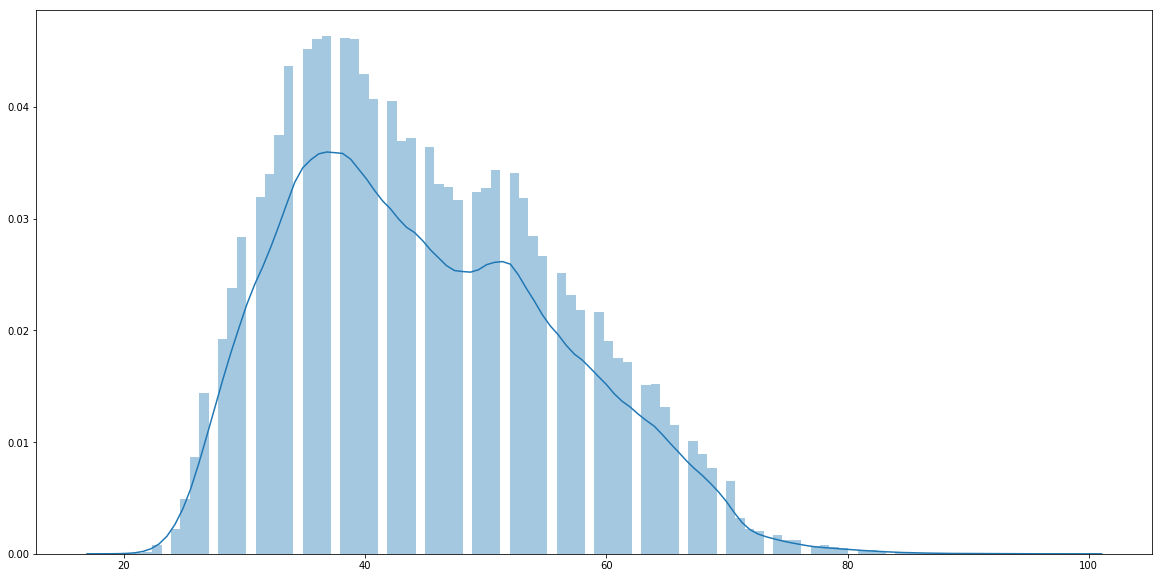

In [29]:
plt.figure(figsize=(20,10))
sns.distplot(x,bins = 100)

In [30]:
1 - scipy.stats.norm(mu, std).cdf(50)

0.3290766260064195